# Periodic Heat Exchanger

![image info](Heat-exchanger.jpg)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import xcompact3d_toolbox as x3d

## Parameters

+ Numerical precision

Use `np.float64` if Xcompact3d was compiled with the flag `-DDOUBLE_PREC`, use `np.float32` otherwise.

In [2]:
x3d.param["mytype"] = np.float64

* Xcompact3d's parameters

For more information about them, checkout the [API reference](https://xcompact3d-toolbox.readthedocs.io/en/latest/Docstrings.html#xcompact3d_toolbox.parameters.Parameters).

In [3]:
prm = x3d.Parameters(
    filename="input.i3d",
    # BasicParam
    itype=12,
    p_row=0,
    p_col=0,
    nx=128,
    ny=129,
    nz=8,
    xlx=6.0,
    yly=6.0,
    zlz=0.375,
    nclx1=0,
    nclxn=0,
    ncly1=2,
    nclyn=2,
    nclz1=0,
    nclzn=0,
    iin=1,
    re=300.0,
    init_noise=0.0125,
    inflow_noise=0.0,
    dt=0.0025,
    ifirst=1,
    ilast=90000,
    ilesmod=1,
    iibm=2,
    gravx=0.0,
    gravy=-1.0,
    gravz=0.0,
    # NumOptions
    nu0nu=4.0,
    cnu=0.44,
    # InOutParam
    irestart=0,
    icheckpoint=45000,
    ioutput=500,
    iprocessing=100,
    # LESModel
    jles=4,
    # ScalarParam
    numscalar=1,
    nclxS1=0,
    nclxSn=0,
    nclyS1=2,
    nclySn=2,
    nclzS1=0,
    nclzSn=0,
    sc=[1.0],
    ri=[-0.25],
    uset=[0.0],
    cp=[1.0],
)

## Setup

### Geometry

Everything needed is in one dictionary of Arrays (see [API reference](https://xcompact3d-toolbox.readthedocs.io/en/latest/Docstrings.html#xcompact3d_toolbox.sandbox.init_epsi)):

In [4]:
epsi = x3d.init_epsi(prm)

The four $\epsilon$ matrices are stored in a dictionary:

In [5]:
epsi.keys()

dict_keys(['epsi', 'xepsi', 'yepsi', 'zepsi'])

Now we draw a cylinder:

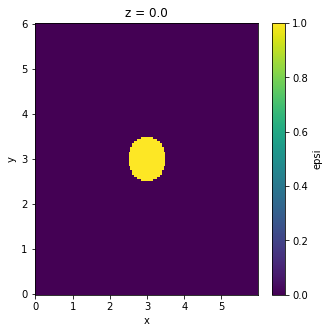

In [6]:
# And apply geo.cylinder over the four arrays
for key in epsi.keys():
    epsi[key] = epsi[key].geo.cylinder(x=prm.xlx / 2.0, y=prm.yly / 2.0,)

# A quickie plot for reference
epsi["epsi"].sel(z=0, method="nearest").plot(x="x", aspect=1, size=5);

The next step is to produce all the auxiliary files describing the geometry, so then Xcompact3d can read them:

In [7]:
%%time
dataset = x3d.gene_epsi_3D(epsi, prm)

prm.nobjmax = dataset.obj.size

dataset

x
       nobjraf : 1
    nobjmaxraf : 1
           bug : 0

y
       nobjraf : 1
    nobjmaxraf : 1
           bug : 0

z
       nobjraf : 1
    nobjmaxraf : 1
           bug : 0

number of points with potential problem in x : 0
number of points with potential problem in y : 0
number of points with potential problem in z : 0

Writing...
Wall time: 4.52 s


<xarray.Dataset>
Dimensions:       (obj_aux: 2, obj: 1, x: 128, y: 129, z: 8)
Coordinates:
  * obj_aux       (obj_aux) int32 -1 0
  * obj           (obj) int32 0
  * x             (x) float64 0.0 0.04688 0.09375 0.1406 ... 5.859 5.906 5.953
  * y             (y) float64 0.0 0.04688 0.09375 0.1406 ... 5.906 5.953 6.0
  * z             (z) float64 0.0 0.04688 0.09375 ... 0.2344 0.2812 0.3281
Data variables: (12/28)
    epsi          (x, y, z) bool False False False False ... False False False
    nobj_x        (y, z) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nobjmax_x     int64 1
    nobjraf_x     (y, z) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nobjmaxraf_x  int64 1
    ibug_x        int64 0
    ...            ...
    nxipif_y      (x, z, obj_aux) int64 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2
    nxfpif_y      (x, z, obj_aux) int64 128 2 128 2 128 2 ... 128 2 128 2 128 2
    xi_z          (x, y, obj) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    xf_z          (x, y, obj) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nxipif_z      (x, y, obj_aux) int64 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2
    nxfpif_z      (x, y, obj_aux) int64 7 2 7 2 7 2 7 2 7 ... 2 7 2 7 2 7 2 7 2

### Boundary Condition

Everything needed is in one Dataset (see [API reference](https://xcompact3d-toolbox.readthedocs.io/en/latest/Docstrings.html#xcompact3d_toolbox.sandbox.init_dataset)):

In [8]:
ds = x3d.init_dataset(prm)

Let's see it, data and attributes are attached, try to interact with the icons:

In [9]:
ds

<xarray.Dataset>
Dimensions:  (x: 128, y: 129, z: 8, n: 1)
Coordinates:
  * x        (x) float64 0.0 0.04688 0.09375 0.1406 ... 5.812 5.859 5.906 5.953
  * y        (y) float64 0.0 0.04688 0.09375 0.1406 ... 5.859 5.906 5.953 6.0
  * z        (z) float64 0.0 0.04688 0.09375 0.1406 0.1875 0.2344 0.2812 0.3281
  * n        (n) int32 1
Data variables:
    byphi1   (n, x, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    byphin   (n, x, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ux       (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    uy       (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    uz       (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    phi      (n, x, y, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    vol_frc  (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

The dimensionless temperature at the objects's surface will always be set to zero by the Immersed Boundary Method, so in opposition to that, let's set the dimensionless temperature at the top and bottom boundaries to one:

In [10]:
for var in "byphi1 byphin".split():
    ds[var] *= 0.0
    ds[var] += 1.0

### Initial Condition

**Velocity profile**: Since the boundary conditions for velocity at the top and at the bottom are no-slip in this case (`ncly2=nclyn=2`), the inflow profile for streamwise velocity must be zero near walls:

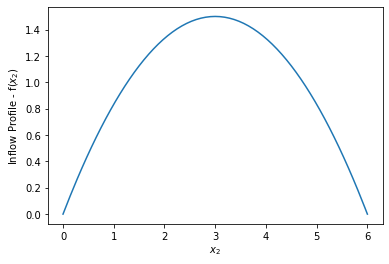

In [11]:
# This function gives the shape
fun = -((ds.y - prm.yly / 2.0) ** 2.0)

# This attribute will be shown in the figure
fun.attrs["long_name"] = r"Inflow Profile - f($x_2$)"

# Now, let's adjust its magnitude
fun -= fun.isel(y=0)
fun /= fun.x3d.simps("y") / prm.yly

fun.plot();

Now, let's make sure that the dimensionless averaged velocity is unitary:

In [12]:
fun.x3d.simps("y") / prm.yly

<xarray.DataArray 'y' ()>
array(1.)

A random noise will be applied at the three velocity components, we can create a modulation function `mod` to control were it will be applied. In this case, we will concentrate the noise near the center region and make it zero were $y=0$ and $y=L_y$. The domain is periodic in $z$ `nclz1=nclzn=0`, so there is no need to make `mod` functions of $z$. The functions looks like:

$$
\text{mod} = \exp\left(-0.5 (y - 0.5 L_y)^2 \right) .
$$

See the code:

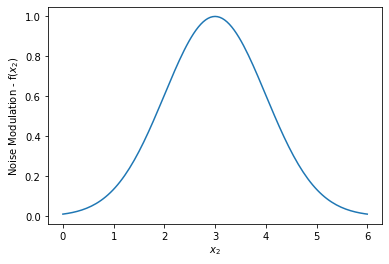

In [13]:
# Random noise with fixed seed,
# important for reproducibility, development and debugging
if prm.iin == 2:
    np.random.seed(seed=67)

mod = np.exp(-0.5 * (ds.y - prm.yly * 0.5) ** 2.0)

# This attribute will be shown in the figure
mod.attrs["long_name"] = r"Noise Modulation - f($x_2$)"

mod.plot();

Now we reset velocity fields `ds[key] *= 0.0`, just to guarantee consistency in the case of multiple executions of this cell.

We then add a random number array with the right shape, multiply by the noise amplitude at the initial condition `init_noise` and multiply again by our modulation function `mod`, defined previously. Finally, we add the streamwise profile `fun` to `ux` and make the plots for reference, I'm adding extra options just to exemplify how easily we can slice the spanwise coordinate and produce multiple plots:

Initial Condition for Streamwise Velocity


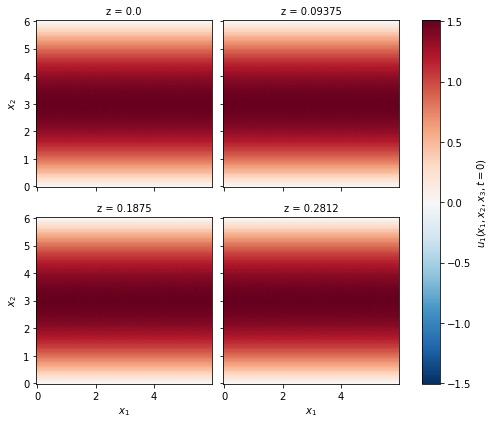

Initial Condition for Vertical Velocity


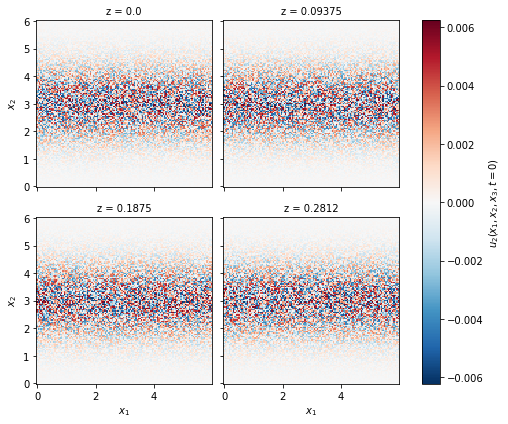

Initial Condition for Spanwise Velocity


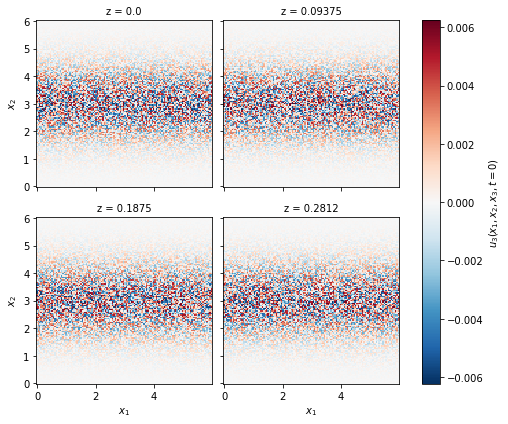

In [14]:
for key in "ux uy uz".split():
    #
    print(ds[key].attrs["name"])
    #
    ds[key] *= 0.0
    ds[key] += prm.init_noise * ((np.random.random(ds[key].shape) - 0.5))
    ds[key] *= mod
    #
    if key == "ux":
        ds[key] += fun
    #
    ds[key].sel(z=slice(None, None, ds.z.size // 3)).plot(
        x="x", y="y", col="z", col_wrap=2, aspect=1, size=3
    )
    plt.show()
    #

plt.close("all")

For temperature, let's start with one everywhere:

In [15]:
ds["phi"] *= 0.0
ds["phi"] += 1.0

## Flow rate control

The *Sandbox flow configuration* is prepared with a forcing term when the flow is periodic in the streamwise direction $x_1$, in order to compensate viscous dissipation and keep the flow rate constant.

It is done with the help of a personalized volumetric integral operator (`vol_frc`), then, the streamwise velocity will be corrected at each simulated time-step as:

```fortran
I = sum(vol_frc * ux)

ux = ux / I
```

For the composed trapezoidal rule in a uniform grid, the integral operator in the vertical direction can be computed as:

$$
vol_{frc} = \Delta y ~ [1/2, 1, \dots, 1, \dots, 1, 1/2]
$$

For a unitary averaged velocity, `vol_frc` must be divided by the domain's heigh. Besides that, for streamwise and spanwise averaged values, `vol_frc` must be divided by `nx` and `nz`.

Finally, `vol_frc` can be coded as:

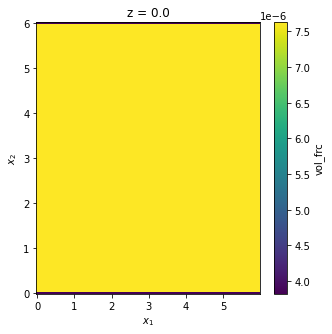

In [16]:
ds["vol_frc"] *= 0.0

ds["vol_frc"] += prm.dy / prm.yly / prm.nx / prm.nz

ds["vol_frc"][dict(y=0)] *= 0.5
ds["vol_frc"][dict(y=-1)] *= 0.5

ds.vol_frc.isel(z=0).plot(x="x", y="y", aspect=1, size=5);

Now, let's make sure that `sum(vol_frc * ux)` is near to one:

In [17]:
(ds.vol_frc * ds.ux).sum(["x", "y", "z"])

<xarray.DataArray ()>
array(0.99994064)

And the last step, we can remove the solid geometry from our integral operator using the code:

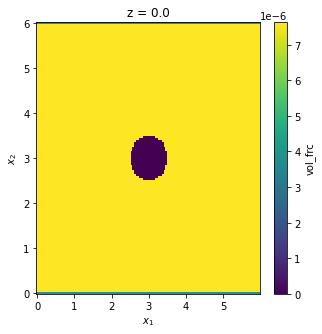

In [18]:
ds["vol_frc"] = ds.vol_frc.where(epsi["epsi"] == False, 0.0)

ds.vol_frc.isel(z=0).plot(x="x", y="y", aspect=1, size=5);

## Writing to the disc

is as simple as:

In [19]:
prm.dataset.write(ds)

In [20]:
prm.write()

## Running the Simulation

It was just to show the capabilities of `xcompact3d_toolbox.sandbox`, keep in mind the aspects of numerical stability of our Navier-Stokes solver. **It is up to the user to find the right set of numerical and physical parameters**.

The Sandbox Flow Configuration is still in prerelease, it can be found at [fschuch/Xcompact3d](https://github.com/fschuch/Xcompact3d).

Make sure that the compiling flags and options at `Makefile` are what you expect. Then, compile the main code at the root folder with `make`.

And finally, we are good to go:

```bash
mpirun -n [number of cores] ./xcompact3d |tee log.out
```